# Creating synthetic Total Rewards data with the Python Faker library

Composition of geographical data: 
- unique 4 digits employee number, starting at 1000
- unique names
- tenure information (start date & termination date)
- department information (sample: HR, Finance, Marketing, Sales, IT, Customer Service, Legal, Project Management)
- hierarchy level (79% individual contributor, 16% manager/director, 5% senior leadership) per this [ratio of individual contributors/managers/directors](https://ravio.com/blog/effective-management-structures-how-to-know-if-your-company-is-too-top-heavy#)
- base salary
- car allowance
- % of equity

In [1]:
# importing Faker library & modules
from faker import Faker
from faker.providers import DynamicProvider
import random
from random import choices

# importing data manipulation libraries
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# importing datetime to convert strings into dates if necessary
from datetime import datetime

In [2]:
# creating a Faker instance in Canada
fake = Faker(locale='en_CA')

# creating the list of hierarchy levels with their weights
hierarchy_pool = ["Individual contributor","Manager/Director",
                  "Senior Leadership"]
h_wts=[0.79,0.16,0.05]

# instancing the dynamic provider
hierarchy_level = DynamicProvider(provider_name="level",
                                  elements=choices(hierarchy_pool,
                                                   weights=h_wts,
                                    k=len(hierarchy_pool)))

# adding the new provider to the Faker instance
fake.add_provider(hierarchy_level)

### Rules for base salary, car allowances and equity %

**Base salary**
- If level is individual contributor, then base is $50k-$90k
- If level is manager/director, then base is $91k-$180k
- If level is senior leadership, then base is >$181k

**Car allowances**
- If level is individual contributor, then allowance is none
- If level is manager/director, then allowance is $1.8k-$3.6k
- If level is senior leadership, then allowance is $4.8k+

**Equity %**
- If level is individual contributor, then equity is none
- If level is manager/director, then equity is 2-5%
- If level is senior leadership, then equity is 6-10%

In [3]:
# creating a function to generate employee records
def create_employees(num_employees):
    employee_list = []
    for i in range(0, num_employees):
        employee = {}

# employee personal info
        employee['ee#'] = 1000+i
        employee['employee_name'] = fake.unique.name()      
        start_date = fake.date()
        employee['start_date'] = start_date
        employee['term_date'] = fake.date_between_dates(
            date_start=datetime.strptime(start_date,"%Y-%m-%d"))
        employee['department'] = fake.random_element(
            elements=("HR","Finance","Marketing","Sales",
                      "IT","Customer Service","Legal",
                      "Project Management"))
        level = fake.level()
        employee['level'] = level

# employee compensation info
# base salary
        if level == 'Individual contributor': 
            employee['base'] = fake.random_int(
                min=50000,
                max=90000,
                step=1000)
        elif level == 'Manager/Director':
            employee['base'] = fake.random_int(
                min=91000,
                max=180000,
                step=1000)
        else:
            employee['base'] = fake.random_int(
                min=181000,
                max=500000,
                step=1000)
# car allowances
        if level == 'Individual contributor': 
            employee['travel_allowance'] = 0
        elif level == 'Manager/Director':
            employee['travel_allowance'] = fake.random_int(
                min=1800,
                max=3600,
                step=100)
        else:
            employee['travel_allowance'] = fake.random_int(
                min=4800,
                step=100)
# equity %
        if level == 'Individual contributor': 
            employee['equity'] = 0
        elif level == 'Manager/Director':
            employee['equity'] = round(random.uniform(2,5),1)
        else:
            employee['equity'] = round(random.uniform(6,10),1)

# append the employee to the list        
        employee_list.append(employee)
    return pd.DataFrame(employee_list)

In [4]:
# creating a dataframe to hold the output of the function
# and visualize it to check for correct output
records = create_employees(5000)
print(records.shape)
print(records.columns)
records.sample(5)

(5000, 9)
Index(['ee#', 'employee_name', 'start_date', 'term_date', 'department',
       'level', 'base', 'travel_allowance', 'equity'],
      dtype='object')


,ee#,employee_name,start_date,term_date,department,level,base,travel_allowance,equity
46,1046,Daniel Davis,1978-07-09,2020-08-21,Finance,Manager/Director,162000,2200,2.1
68,1068,Jennifer Harris DDS,2011-04-01,2021-04-09,Legal,Individual contributor,74000,0,0.0
4186,5186,Barbara Carpenter,2016-11-15,2018-10-23,Sales,Manager/Director,169000,1900,3.7
1563,2563,Timothy Horn,2007-09-02,2020-11-07,HR,Senior Leadership,190000,8900,9.4
3910,4910,Scott Collins,2017-09-23,2021-03-13,Legal,Manager/Director,93000,2100,2.4


## Exploratory data analysis & quality control

In [5]:
# categorical data profiling with formatted outputs
def category_profiling(df, cat_columns):
    print(df.nunique())
    print("---")
    print(df.dtypes)
    print("---")
    for col in cat_columns:
        percentages = df[col].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
        print(percentages)
        print("---")

cat_columns = ['department', 'level']

category_profiling(records, cat_columns)

ee#                 5000
employee_name       5000
start_date          4441
term_date           4010
department             8
level                  3
base                 447
travel_allowance      72
equity                73
dtype: int64
---
ee#                   int64
employee_name        object
start_date           object
term_date            object
department           object
level                object
base                  int64
travel_allowance      int64
equity              float64
dtype: object
---
department
Sales                 13.0%
Project Management    13.0%
Finance               12.7%
HR                    12.7%
IT                    12.6%
Legal                 12.2%
Marketing             11.9%
Customer Service      11.9%
Name: proportion, dtype: object
---
level
Manager/Director          33.7%
Senior Leadership         33.6%
Individual contributor    32.7%
Name: proportion, dtype: object
---


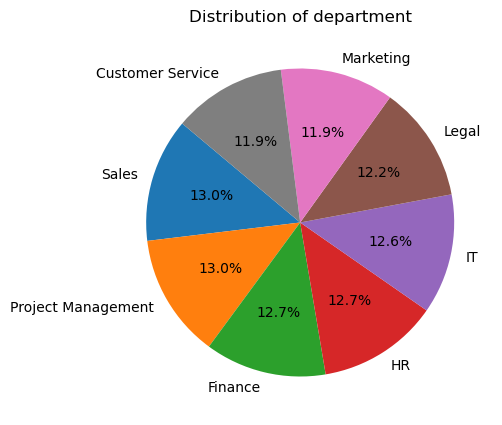

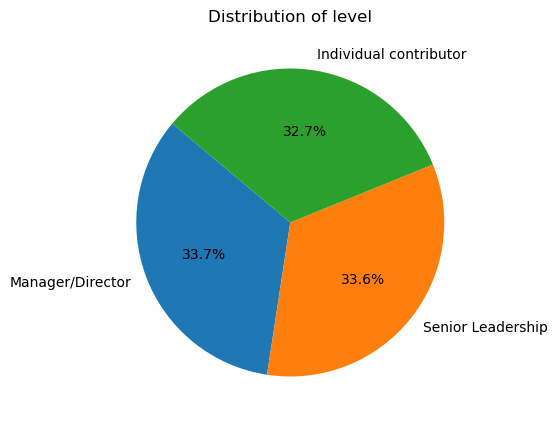

In [6]:
# plotting categorical columns' distributions
def cat_distribution_plots(data, cat_columns):
    for col in cat_columns:
        graph_data= data[col].value_counts()

        plt.figure(figsize= (10,5))
        plt.pie(graph_data.values,
                labels= graph_data.index,
                autopct= '%1.1f%%',
                startangle= 140)
        plt.title(f'Distribution of {col}')
        plt.show()

cat_distribution_plots(records, cat_columns)

In [7]:
# numerical data profiling with formatted outputs
def numerical_profiling(df,num_columns):
    for col in num_columns:
        column = df[col]
        stats = {
            "min": column.min(),
            "max": column.max(),
            "avg": column.mean().round(0),
            "stdev": column.std(),
            "1st quartile": np.percentile(a= column, q= 25),
            "2nd quartile": np.percentile(a= column, q= 50),
            "3rd quartile": np.percentile(a= column, q= 75),
            "skew": skew(column, axis=0, bias=True),
            "kurtosis": kurtosis(column, axis=0, 
                                 fisher=True, bias=True)}
        
        print(f"Statistics for {col.capitalize()}:")
        for stat, value in stats.items():
            print(f"{stat}: {value}")
        print("---")

num_columns = ['base', 'travel_allowance', 'equity']

numerical_profiling(records, num_columns)

Statistics for Base:
min: 50000
max: 500000
avg: 182590.0
stdev: 127673.65918078013
1st quartile: 81000.0
2nd quartile: 137000.0
3rd quartile: 264000.0
skew: 0.9974952899256215
kurtosis: -0.27844690315681664
---
Statistics for Travel_allowance:
min: 0
max: 9900
avg: 3367.0
stdev: 3169.784422047859
1st quartile: 0.0
2nd quartile: 2700.0
3rd quartile: 6100.0
skew: 0.5470165961473105
kurtosis: -0.9971768779954684
---
Statistics for Equity:
min: 0.0
max: 10.0
avg: 4.0
stdev: 3.3744719258805698
1st quartile: 0.0
2nd quartile: 3.5
3rd quartile: 7.0
skew: 0.2683399251838705
kurtosis: -1.3001206468802056
---


## Exporting the dataframe to .csv once ready

In [ ]:
records.to_csv('records_df.csv', index=False)